# Battery Exploration Example

This Data exploration guide will analyze data from the SunPower hackathon's battery dataset. The analysis will determine if there is sufficient and valuable data to perform battery operation modeling. To achieve this goal, I will conduct 6 steps:
1. Load the data
2. Analyze basic information
3. Check data by battery id, time, and charge
4. Analysis and Unsupervised modeling
5. Anomaly detection
6. Operation Optimization

# 1. Loading Data
In this section, we will import basic libraries, read csv data, organize our data frame, and set the datatypes of columns.


We import the following libraries
1. numpy - math, matricies, and array opperations
2. pandas - DataFrame library
3. matplotlib - plotting and visualization library
4. seaborn - fancy graphs
5. isolationForest - machine learning model to spot anomalies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [2]:
# for plotting
a4_dims = (11.7, 8.27)

We create a variable for the file name and it's path if it is outside of our local directory. Next, we read the csv file into a dataframe with pandas. I'll specify the index column and tell pandas I expect the index to be dates. 
I added these parameters after I first loaded 100 records into the dataframe and checked the entries. You can see this process on line 2 in the next cell. It's always good to load a small amount of data and check the values inside before loading a large dataset into memory.

In [3]:
file_path = r'b9c5abaa-28bd-4c7b-9632-01ca823fb585.csv'
#df = pd.read_csv(file_path, nrows=100)
df = pd.read_csv(file_path, index_col=1, parse_dates=True)#, nrows=10000)
df.head()
#print(df.head())

,srhid,timeseriesname,timeseriesvalue
timeseriestimestamp,,,
2018-04-03 00:30:00,1075016781,powerProduction,0.000000
2018-04-02 23:20:01,1075016781,batteryPercentageState,19.546785
2018-04-02 23:25:00,1075016781,batteryPercentageState,19.561863
2018-04-03 01:30:01,1075016781,batteryPercentageState,19.524618
2018-04-03 01:00:00,2101522395,powerProduction,0.000000


The data is loaded! There are 4 different features: the index and 3 columns. Below is a table describing the dataset. 
1. timeseriestimestamp (index) - the datetime of the event (datetime)
2. srhid - the batteries serial number (categorical)
3. timeseriesname - the action the battery performs at the timestamp (categorical)
4. timeseriesvalue - the value of the battery action (numeric, positive, sometimes a percentage)

For example, the first record shows that battery id 1075016781 had powerProduction of 0.000 on 2018-04-03 00:30:00

In [4]:
# the first record output 
df.iloc[0,:]

srhid                   1075016781
timeseriesname     powerProduction
timeseriesvalue                  0
Name: 2018-04-03 00:30:00, dtype: object

Next, we set the metadata of the dataframe. We need to verify the column names, and set each column to it's correct data type. 
Calling the strip function on the column names will remove any white space from the text. It's just one of many ways to create usable column names in a dataframe. Another meaningful step might be to replace spaces with underscores in any column text (i.e. "column 1" -> "column_1")
Next, we set the columns to be the correct datatype in case pandas has incorrectly converted the data. One way to do this is with a dictionary of the column names and the datatype to be cast. Another method is the one seen below - using the astype function. 
Lastly, we print out the details about the dataframe using the info function. We add the head of the dataframe to see a small sample of the data in a table.

In [5]:
df.columns = df.columns.str.strip()
df.loc[:,'srhid'] = df.srhid.astype(str)
df.loc[:,'timeseriesname'] = df.timeseriesname.astype(str)
df.loc[:,'timeseriesvalue'] = df.timeseriesvalue.astype(np.float)
print(df.info())
print('DataFrame column types: \n',df.dtypes)
print('-----------------\nData sample:\n')
print('\n\nDataFrame head: \n',df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19091122 entries, 2018-04-03 00:30:00 to 2017-11-24 19:40:01
Data columns (total 3 columns):
srhid              object
timeseriesname     object
timeseriesvalue    float64
dtypes: float64(1), object(2)
memory usage: 622.6+ MB
None
DataFrame column types: 
 srhid               object
timeseriesname      object
timeseriesvalue    float64
dtype: object
-----------------
Data sample:



DataFrame head: 
                           srhid          timeseriesname  timeseriesvalue
timeseriestimestamp                                                     
2018-04-03 00:30:00  1075016781         powerProduction         0.000000
2018-04-02 23:20:01  1075016781  batteryPercentageState        19.546785
2018-04-02 23:25:00  1075016781  batteryPercentageState        19.561863
2018-04-03 01:30:01  1075016781  batteryPercentageState        19.524618
2018-04-03 01:00:00  2101522395         powerProduction         0.000000


In [6]:
# check for nans in numeric column
print('checking for nan values...\n\n',df[df['timeseriesvalue'].isna()].head())

# drop nan records
df.dropna(axis=0,inplace=True)
print('records dropped')
print(df[df['timeseriesvalue'].isna()].head())

checking for nan values...

                           srhid          timeseriesname  timeseriesvalue
timeseriestimestamp                                                     
2017-05-12 11:14:59  1682950526  batteryPercentageState              NaN
2017-05-12 11:34:59  1682950526  batteryPercentageState              NaN
2017-05-12 11:54:59  1682950526  batteryPercentageState              NaN
2017-05-12 12:24:59  1682950526  batteryPercentageState              NaN
2017-05-12 12:29:59  1682950526  batteryPercentageState              NaN
records dropped
Empty DataFrame
Columns: [srhid, timeseriesname, timeseriesvalue]
Index: []


It turns out that the seaborn library will not work well with our categorical column srhid. This column is the serial id of each battery, but seaborn thinks that the value should be cast as numerical, even though we have casted it as a string. Later, we will add a single character to the IDs to trick seaborn.

# 2. Analyze basic information
Now that we have the DataFrame created, it's time to explore the data we have. We can look at data in a single collumn, the relationships between columns, and more. 

## Sections
### 2.1 Exploring Time
### 2.2 Exploring srhid
### 2.3 Exploring timeseriesname
### 2.4 Exploring timeseriesvalue


Let's take a look at what kind of data is in each column, starting from left to right.


# 2.1 Exploring Time
The battery dataset is timeseries data, with the index column being the datetime. Let's take a look at the first and last dates in the dataset

In [7]:
# plot the first and last entries,
# plot the count of entries overtime
#min(df.head().index)
print('the first and last dates in the dataframe are ', min(df.index), ' and ', max(df.index))


the first and last dates in the dataframe are  2016-12-31 14:00:00  and  2018-04-12 05:09:46


Let's visualize when the battery actions take place over time. We do this by grouping actions by a time frequency (like month or day) and then plotting the actions that occur in this time period.

C:\Users\slin2\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

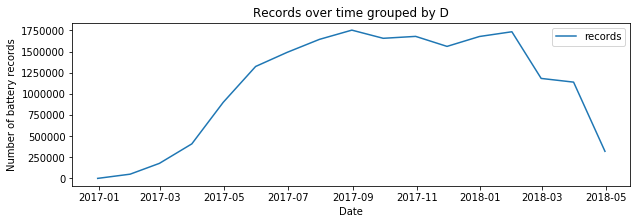

In [8]:
freq = 'd'
temp = df.groupby(pd.Grouper(freq='m')).count()
#temp.head()
fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(temp.index, temp['srhid'], label='records')
ax.set_title('Records over time grouped by {}'.format(freq.upper()))
ax.set_ylabel('Number of battery records')
ax.set_xlabel('Date')
ax.legend()

In [20]:
# remember to dedup the records

2.2 Exploring srhid
The srhid column is the batteries serial number. Let's look at how the data is split up by battery. We can look at what are the unique batteries and when they were installed (when they enter the dataset).

There are 41 unique srhids in the data, each representing a different battery


Text(0, 0.5, 'count of records')

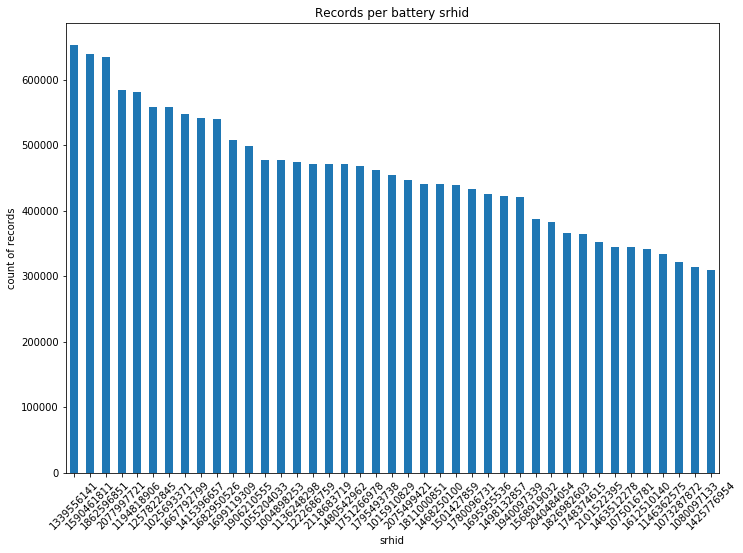

In [9]:
print('There are {} unique srhids in the data, each representing a different battery'.format(df['srhid'].nunique()))
df['srhid'].value_counts()
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = df['srhid'].value_counts().plot.bar(title='Records per battery srhid', rot=45)
ax.set_xlabel('srhid')
ax.set_ylabel('count of records')    

We expect batteries entering the dataset to be installed, and batteries leaving the dataset to be decomissioned. 
The graph below shows the number of operational batteries over time.


Text(0.7, 0.7, 'Single battery \ndecomission')

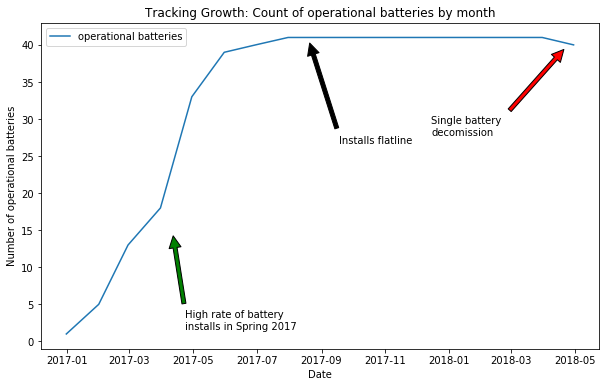

In [10]:
# plot operational batteries overtime (installs)
# how many batteries were installed overtime
temp = df.groupby(pd.Grouper(freq='m'))['srhid'].nunique().reset_index()
temp.head()
print('We expect batteries entering the dataset to be installed, and batteries leaving the dataset to be decomissioned. \n'+
    'The graph below shows the number of operational batteries over time.')
fig, ax = plt.subplots(figsize=(10,6))
#fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(temp['timeseriestimestamp'], temp['srhid'], label='operational batteries')
ax.set_title('Tracking Growth: Count of operational batteries by month')
ax.set_ylabel('Number of operational batteries')
ax.set_xlabel('Date')
ax.legend()
#ax.annotate('rapid installs in Spring 2017', xy=(250, 100), xycoords='figure pixels')
ax.annotate('High rate of battery \ninstalls in Spring 2017',
            xy=(.28, .4), xycoords='figure fraction',
            xytext=(.3,.2),
            horizontalalignment='left', verticalalignment='top',
            arrowprops=dict(facecolor='green', shrink=0.05),
            fontsize=10)
ax.annotate('Installs flatline',
            xy=(.5, .9), xycoords='figure fraction',
            xytext=(.55,.65),
            horizontalalignment='left', verticalalignment='top',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=10)
ax.annotate('Single battery \ndecomission',
            xy=(.92, .88), xycoords='figure fraction',
            xytext=(.7,.7),
            horizontalalignment='left', verticalalignment='top',
            arrowprops=dict(facecolor='red', shrink=0.05),
            fontsize=10)

## 2.3 Exploring timeseriesname
This column contains the actions the batteries perform (so we think!). Let's explore what are the possible actions and how they are represented in the data.
What are the different types of actions a battery can perform? Is the dataset organized appropriately?


In [11]:
# what are the unique values in the timeseriesname column?
print('the unique actions the battery can take are: ')
# identify different timeseriesname
print(df['timeseriesname'].unique())

the unique actions the battery can take are: 
['powerProduction' 'batteryPercentageState' 'powerFeedIn'
 'powerSelfConsumption' 'powerPurchased' 'powerConsumption']


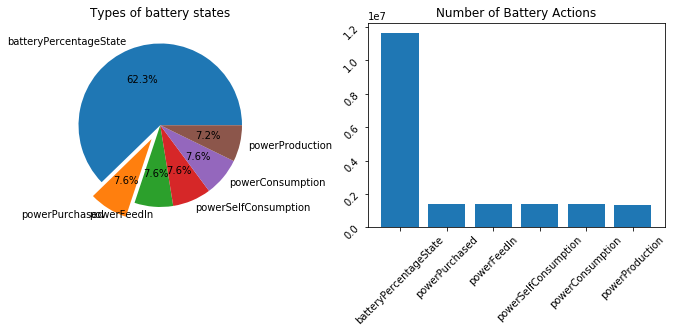

In [12]:
# battery states and actions
vals, cats = df['timeseriesname'].value_counts(),df['timeseriesname'].value_counts().index
fig = plt.figure(figsize=a4_dims)
ax1 = fig.add_subplot(221)
ax1.set_title('Types of battery states')
explode = (0,0.2,0,0,0,0)
ax1.pie(vals, labels=cats, autopct='%1.1f%%',explode=explode)
ax2 = fig.add_subplot(222)
ax2.set_title('Number of Battery Actions')
ax2.bar(cats, vals)
ax2.tick_params(labelrotation=45)

It looks like there are two related pieces of data in this dataset! One is the batteryPercentState which represents the % capacity of the battery at a given timestamp. The other are the 5 battery actions that can be performed. Their values are the gross energy charged or dischared from the battery, not a percentage of the capacity. Let's split this data into two different datasets, considering they have different values and represent different information on the battery.

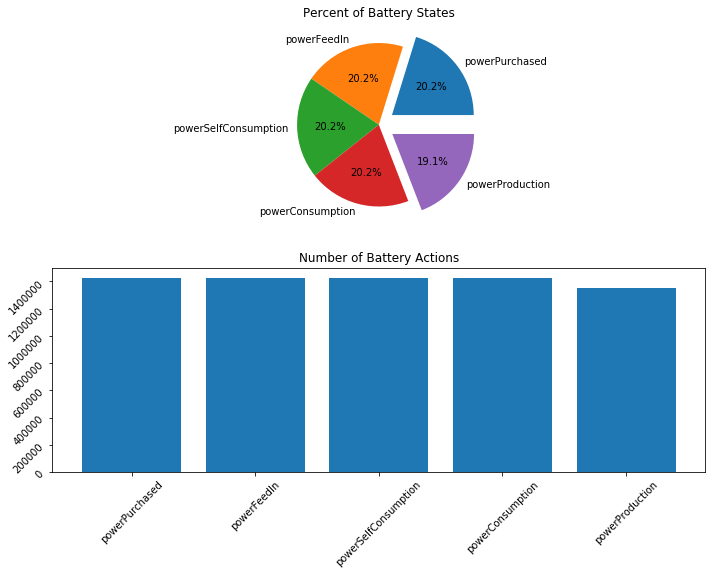

In [13]:
cat, vals = df[df['timeseriesname']!='batteryPercentageState']['timeseriesname'].value_counts().index, df[df['timeseriesname']!='batteryPercentageState']['timeseriesname'].value_counts()
fig, (ax1, ax2) = plt.subplots(2, figsize=a4_dims)
ax1.set_title('Percent of Battery States')
explode = (0.2,0,0,0,0.2)
ax1.pie(vals, labels=cat, autopct='%1.1f%%',explode=explode)
#ax1.legend()

ax2.bar(cat, vals)
ax2.set_title('Number of Battery Actions')
ax2.tick_params(labelrotation=45)
plt.show()


The data types of the columns are: 
 srhid               object
timeseriesname      object
timeseriesvalue    float64
dtype: object


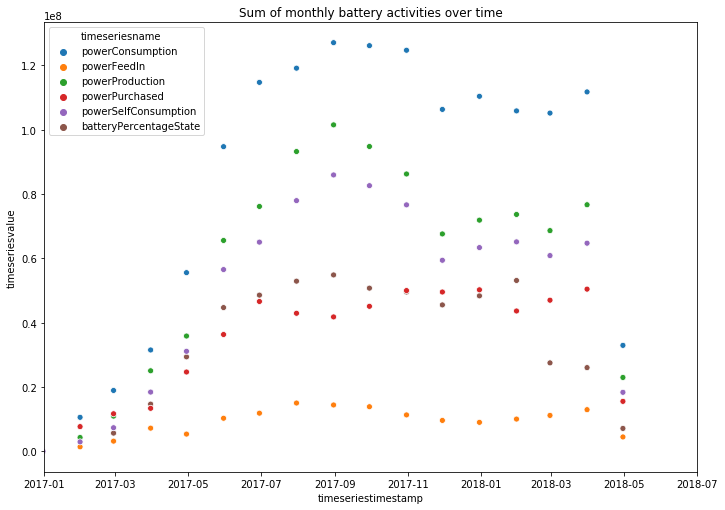

In [14]:
# convert timeseries name to string
#df['timeseriesname'] = df['timeseriesname'].apply(str)
print('\nThe data types of the columns are: \n',df.dtypes)
temp = df.groupby(by=[pd.Grouper(freq='M'),'timeseriesname']).sum().reset_index()
#temp.head()
fig = plt.subplots(figsize=a4_dims)
g = sns.scatterplot(data=temp, x='timeseriestimestamp',y='timeseriesvalue', hue='timeseriesname')
start, end = pd.datetime(2017,1,1), pd.datetime(2018,7,1)
g.set_xlim(start, end)
plt.title('Sum of monthly battery activities over time')
#sns.set_title('Sum of monthly battery activities over time')
plt.show()
#g.xlim(pd.datetime(2016,1,1), None)

#sns.scatterplot(data=df,x=df.index,y=df['timeseriesvalue'],hue=df['timeseriesname'])

C:\Users\slin2\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0
1
2
complete!


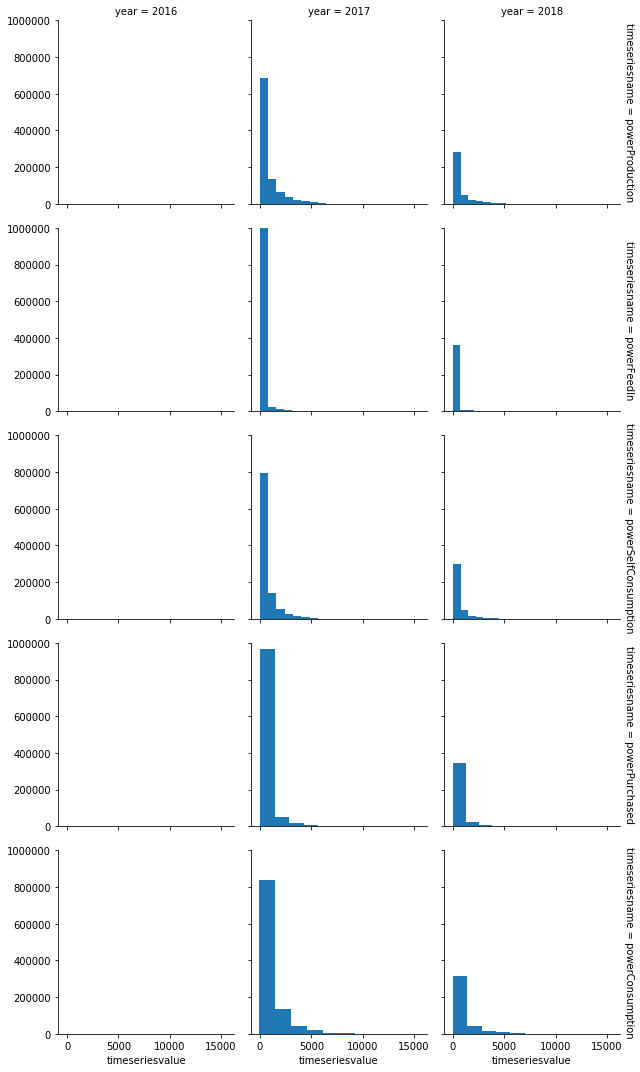

In [15]:
temp = df[df['timeseriesname'] != 'batteryPercentageState']
temp['year'] = temp.index.year
#temp = df['timeseriesname','timeseriesvalue'].pivot(index='')
g = sns.FacetGrid(temp, row='timeseriesname', col='year', margin_titles=True)
g.map(plt.hist, 'timeseriesvalue')
axes = g.axes
for i in range(temp.year.nunique()):
    print(i)
    for j in range(temp.timeseriesname.nunique()):
        axes[j,i].set_ylim(0,1000000)

        #ax.set(ylim=(0, 10000))
print('complete!')

#  2.3 Exploring timeseriesvalue
In this section, we'll look at some of the values in the timeseriesvalue column. We will investigate a numeric column for the first time using descriptive statistics and box plots.

Before we get started, recall that in our last section, we discovered that the dataset contains 2 types of data:
1. The batterypercentagestate which is a value between 0-100 percent. This value describes the capacity of the battery at a given time, or to use an analogy of a water glass, how "full" is the battery. In this case, 0 would be empty, and 100 would be completely full (at full capacity). 
2. The energy change caused by a battery action in units energy (potentially Wh) in the range of [0 , inf). The battery actions describe the energy being charged or discharged from the battery. An example would be powerFeedIn with a value of 500, which would indicate that 500 units of energy would be entering the battery from the energy feed. 

Let's look at the descriptive statistics on the center and spread of the data:

In [16]:
print('all actions')
print(df.describe().transpose())
print('\n\nwithout battery percent')
print(df[df['timeseriesname']!='batteryPercentageState'].describe().transpose())


all actions
                      count       mean         std       min       25%  \
timeseriesvalue  18701490.0  240.36191  638.433006 -91.23356  5.989863   

                       50%    75%        max  
timeseriesvalue  48.666668  100.0  15512.684  


without battery percent
                     count       mean         std       min  25%        50%  \
timeseriesvalue  7055799.0  557.86366  957.074167 -91.23356  0.0  170.66667   

                      75%        max  
timeseriesvalue  686.5688  15512.684  


{'whiskers': [<matplotlib.lines.Line2D at 0x227973c8e10>,
 'caps': [<matplotlib.lines.Line2D at 0x227973d4550>,
 'boxes': [<matplotlib.lines.Line2D at 0x227973c8a20>],
 'medians': [<matplotlib.lines.Line2D at 0x227973d4be0>],
 'fliers': [],
 'means': []}

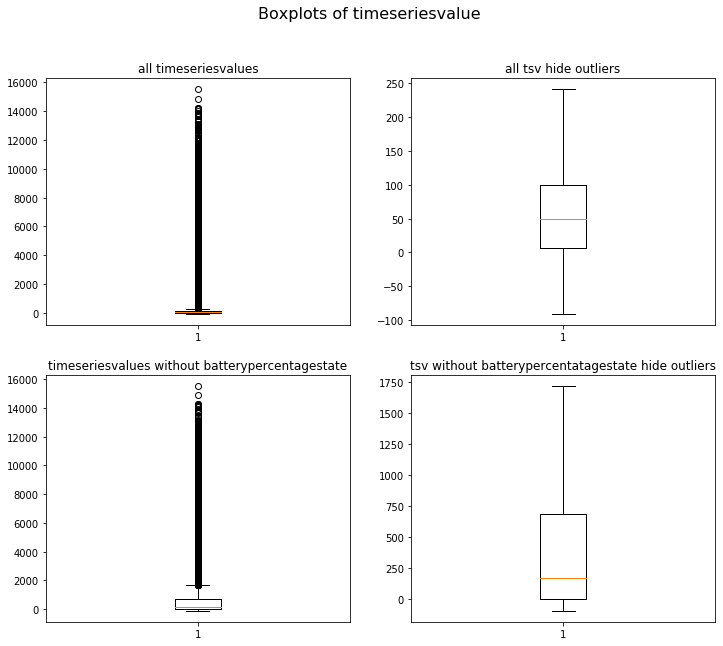

In [17]:
#df.boxplot(column='timeseriesvalue')
fig = plt.figure(figsize=(12,10))
fig.suptitle('Boxplots of timeseriesvalue', fontsize=16)
ax1 = fig.add_subplot(221)
ax1.boxplot(df['timeseriesvalue'])
ax1.set_title('all timeseriesvalues')
ax3 = fig.add_subplot(222)
ax3.set_title('all tsv hide outliers')
ax3.boxplot(df.timeseriesvalue, showfliers=False)

ax2 = fig.add_subplot(223)
ax2.set_title('timeseriesvalues without batterypercentagestate')
ax2.boxplot(df[df['timeseriesname']!='batteryPercentageState']['timeseriesvalue'])
ax4 = fig.add_subplot(224)
ax4.set_title('tsv without batterypercentatagestate hide outliers')
ax4.boxplot(df[df['timeseriesname']!='batteryPercentageState']['timeseriesvalue'], showfliers=False)

This graph shows the range of values of the timeseriesvalue column. From the prior analysis on the battery actions (the timeseriesname column), we found that the timeseriesvalue has two types of entries - the battery percentage state (capacity percentage) and the raw energy charged or discharged. Having both values, each with different units, is determental to any mathematical or statistical analysis. 
Normally, we would explore numeric data by looking at the range of values present. A good tool for this exploration is the boxplot.
1. In the first plot (upper left), we see all of the values plotted. The mean is somewhere below 2000, with many outliers above the 75 percentile. This boxplot tells us that the data sits in a very narrow range with some massive outliers. Expect the mean of the data to be very skewed and misrepresentative. 
2. In the second plot (upper right), we zoom in on the actual boxplot to see the median, IQR, and "min" and "max"'s. There is a negative value, which breaks some of our data assumptions, and we notice that the battery percent values (range between 0-100) are affecting the spread.
3. In the third plot (bottom left), we have removed the battery percent data. This boxplot shows only the charge and discharge data. A wider IQR can be seen compared to the first plot.
4. In the fourth plot (bottom right), we hide the outliers and zoom in on the box. We see that the median has risen considerably now that we have removed the battery percentage values. 
Conclusion: The data is muddy and we need to separate the percentages from the raw energy values.

From this graph, we can see that the data looks drastically different with and without the batterypercentagestate category. This is just further reason to separate the raw energy values and the percentage of battery capacity from the dataset. 

# Data Cleaning and Processing
In this section we will fix any issues found in the exploration.
## 3.1 Convert srhid to strings
## 3.2 Separation of Categorical timeseriesname Data
## 3.3 Removal of negative energy values 
## 3.4 Divide battery action into charge or drain
## 3.5 Creating netenergy column
## 3.6 Conserving energy: Do battery actions make sense?


# 3.1 Convert srhid to strings
It is reasonable to assume that we do not need to convert the srhid to a string. If we check the datatype of the values in the srhid column, we can see that the values are in fact strings. We even did the string casting back in section 1 to convert the entire column. However, the seaborn graphing package will throw an error when trying to graph categorical data (like strings) that looks like numeric values. For example, seaborn will refuse to recognize groups called "1" "2" and "3" even though they are formatted as strings. Seaborn checks to see if they can fit as numeric values, and converts them to numbers automatically. This can cause problems and tons of headaches. 

We will trick seaborn by adding an underscore ('\_') to every srhid in the data.


In [18]:
# required to make a 'float' a hue value in sns
# there is a bug that makes sns think that the data is not categorical if it looks like a number
# https://stackoverflow.com/questions/51525284/the-hue-parameter-in-seaborn-relplot-skips-an-integer-when-given-numerical-d
df['srhid'] = df['srhid'].apply(lambda x: '_'+x)
print('Examples of new srhid\'s : \n{}'.format(df['srhid'].unique()[0:5]))

Examples of new srhid's : 
['_1075016781' '_2101522395' '_1682950526' '_1811000851' '_1073287872']


# 3.2 Separation of Battery Actions


The column timeseriesname contains different data for the battery. 5 of these values look like battery actions while 1 value looks like the instantaneous battery capacity. 
First, let's look at the first five data values: powerConsumption, powerSelfConsumption, powerPurchased, powerFeedIn, and powerProduction. We notice that the actions the battery can take fall into two categories - charging the battery and discharging (which we will call "drain"). These actions have continuous values from 0 to infinity where the units are in energy or power (kWh or Wh likely). 
The batteryPercentageState is not an action but the current capacity of the battery as a percentage from 0-100. 

For analysis, we separate the batteryPercentageState from the other actions.

In [19]:
# separate battery percent
is_battery_percent = df['timeseriesname'] == 'batteryPercentageState'
# make a new dataframe for the batterypercentstate
battery_percent_df = df[is_battery_percent]
# remove the batterypercentstate data from the battery actions
#df.drop(df[is_battery_percent].index, axis=0, inplace=True) 
df = df[df['timeseriesname']!= 'batteryPercentageState'] # faster

# 3.3 Removal of negative energy values
From the numerical analysis perfromed in section 2.3, we found some negative energy values in some of the battery actions. Unless we receive some clarification, these values are bad data. Let's located them, and remove them.
While we are at it, we can remove any values with 0 energy change to the battery. These actions are the same as no action, and for that reason, we do not need them in a dataset containing battery actions.

In [20]:
print('The negative values in the dataset: \n')
df[df['timeseriesvalue'] < 0]

The negative values in the dataset: 



,srhid,timeseriesname,timeseriesvalue
timeseriestimestamp,,,
2017-05-05 17:45:00,_1682950526,powerConsumption,-63.921368
2017-05-05 16:00:00,_1682950526,powerConsumption,-91.233560


In [21]:
# drop negative and zero values
df = df[ df['timeseriesvalue'] > 0 ]
print('zero and negative values dropped')

zero and negative values dropped


# 3.4 Divide battery action into charge or drain
In this section, we will make a guess as to how the battery actions are divided into charging actions or draining actions.

A charge is something that adds energy to the battery. A discharge is an action where energy is leaving the battery. To limit confusion between such close words, we will use the word "drain" for any discharge actions.

In [22]:
# make drain/charge battery state
increase_battery_charge_states = ['powerProduction','powerFeedIn','powerPurchased']
decrease_battery_charge_states = ['powerSelfConsumption','powerConsumption']
df.loc[df['timeseriesname'].isin(increase_battery_charge_states), 'batterystate'] = 'charge'
df.loc[df['timeseriesname'].isin(decrease_battery_charge_states), 'batterystate'] = 'drain'

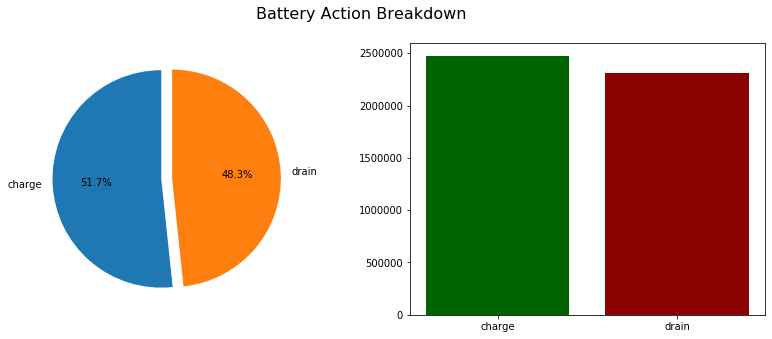

    index  batterystate
0  charge       2473949
1   drain       2313429


In [23]:
#df['batterystate'].value_counts().plot.bar()
temp = df['batterystate'].value_counts().reset_index()
#fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
fig = plt.figure(figsize=(14,5))
fig.suptitle('Battery Action Breakdown', fontsize=16)
ax1 = fig.add_subplot(121)
explode = (0,.1)
ax1.pie(temp['batterystate'], labels=temp['index'], autopct='%1.1f%%',explode=explode, startangle=90)

#fig, (ax1, ax2) = plt.subplots(2)
ax2 = fig.add_subplot(122)
#ax3 = fig.add_subplot(223)
ax2.bar(temp['index'], temp.batterystate, color=('darkgreen','darkred'), label=temp['batterystate'])
#ax2.set_title('Number of Battery Actions')
#ax2.tick_params(labelrotation=45)
plt.show()
print(temp.head())

  batterystate    count
0       charge  2473949
1        drain  2313429


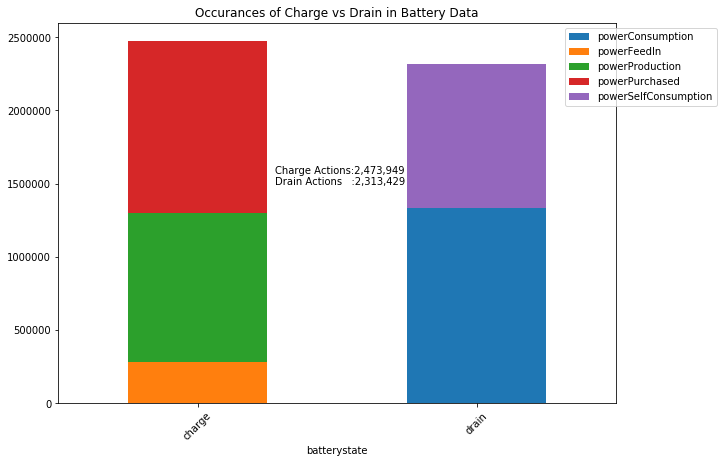

In [24]:
temp = df.groupby(['batterystate','timeseriesname']).agg({'srhid':'count'}).reset_index()#.rename(columns={'srhid':''})
battery_state_totals = df.groupby('batterystate')['srhid'].count().reset_index().rename(columns={'srhid':'count'})
print(battery_state_totals)
temp = temp.pivot(index='batterystate',columns='timeseriesname',values='srhid')
#temp.head()
ax = temp.plot.bar(stacked=True, figsize=(10,7), rot=45)
ax.set_title('Occurances of Charge vs Drain in Battery Data')
ax.annotate('Charge Actions:{0:,}\nDrain Actions   :{1:,}'.format(
    battery_state_totals.loc[0,'count'],battery_state_totals.loc[1,'count']),
            xycoords='figure fraction', xytext=(0.38,0.6), xy=(0.1,0.4) )
ax.legend(bbox_to_anchor=(.9, 1.0))
#ax.text()


Next, we will take the df with the battery actions and determine if the actions are charging or draining the battery.

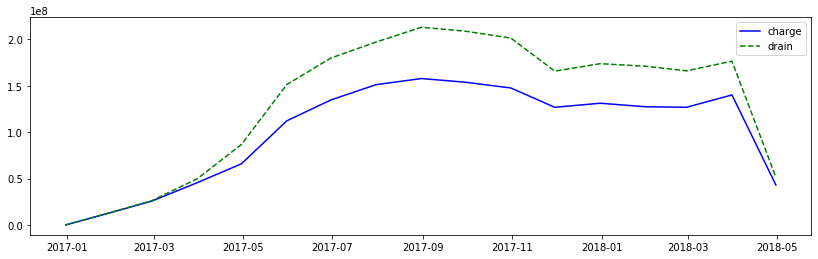

In [25]:
temp = df.groupby([pd.Grouper(freq='m'),'batterystate']).sum().reset_index()
#temp.head()
fig = plt.figure(figsize=(14,4))
plt.plot(temp[temp['batterystate']=='charge'].timeseriestimestamp,temp[temp['batterystate']=='charge'].timeseriesvalue,
        color='blue', label='charge')
plt.plot(temp[temp['batterystate']=='drain'].timeseriestimestamp,temp[temp['batterystate']=='drain'].timeseriesvalue,
        color='green', linestyle='dashed',label='drain')
plt.legend()

In [ ]:
# make a bar chart of average energy by battery actions, with an error bar (could be a box plot I guess)
# make bubble map srhid with count of entries and size = sum of timeseriesvalues 
# Do a k means clustering of the battery values - 
# Active (busy), Active, and inactive maybe?
# make a grid histogram of each type of battery action
# https://seaborn.pydata.org/examples/faceted_histogram.html

In [180]:
#temp = df.groupby([pd.Grouper(freq='m'),'timeseriesname']).sum()
#temp.head()

temp.loc['2017-01-31']

timeseriesvalue
timeseriestimestamp timeseriesname                       
2017-01-31          powerConsumption         1.058730e+07
                    powerFeedIn              1.418495e+06
                    powerProduction          4.306271e+06
                    powerPurchased           7.697997e+06
                    powerSelfConsumption     2.953525e+06

# 3.5 Net Energy
Next, we will make a column for Net Energy. The "netenergy" feature will have positive values of energy for charging actions and negative values for drain actions. 

In [27]:
# add net power using lambda function
df['netenergy'] = df.apply(lambda x: -1 * x.timeseriesvalue if x.batterystate == 'drain' else x.timeseriesvalue, axis=1)
df.head()

,srhid,timeseriesname,timeseriesvalue,batterystate,energy
timeseriestimestamp,,,,,
2018-04-03 01:45:00,_1811000851,powerSelfConsumption,2.00000,drain,-2.00000
2018-04-03 00:45:00,_1075016781,powerPurchased,496.61090,charge,496.61090
2018-04-03 00:30:00,_1075016781,powerConsumption,426.03870,drain,-426.03870
2018-04-03 00:15:00,_1075016781,powerPurchased,378.31793,charge,378.31793
2018-04-03 01:30:00,_2101522395,powerPurchased,801.76280,charge,801.76280


Text(0.5, 0.5, 'annotation')

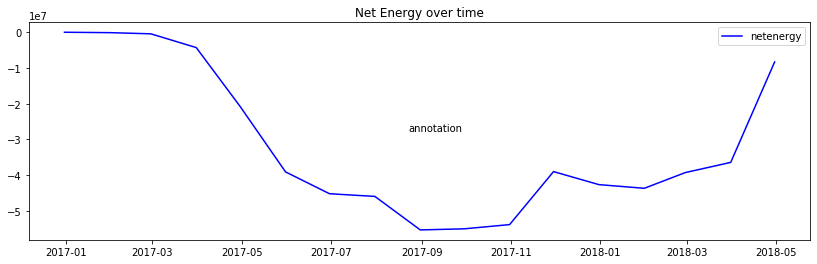

In [30]:
temp = df.groupby(pd.Grouper(freq='m')).agg({'netenergy':'sum','timeseriesvalue':'sum'})
fig = plt.figure(figsize=(14,4))
plt.plot(temp.index,temp.netenergy,
        color='blue', label='netenergy')
plt.legend()
plt.title('Net Energy over time')
plt.annotate('Impossibly low drain over a year', xy=(0.5,.5),xycoords='figure fraction')
#plt.plot(temp.index,temp.timeseriesvalue,
#        color='green', linestyle='dashed',label='raw energy')

## 3.6 Conservation of Energy
This section will look at the conservation of energy of the fleet of batteries. We expect that the batteries will charge and drain in roughly equal amounts over a large time period to satisfy the conservation of energy. Since the battery cannot create nor destroy electrons, we assume that equal ammounts will be entering and leaving the battery.


In [34]:
energy_df = df.reset_index().pivot(index=['srhid','timeseriestimestamp'], columns='timeseriesname', values='netenergy')
energy_df.head()
#temp = df.groupby(['srhid',pd.Grouper(freq='d')])

NotImplementedError: > 1 ndim Categorical are not supported at this time

In [86]:
# group net power by date
# https://stackoverflow.com/questions/39400115/python-pandas-group-by-date-using-datetime-data
out = df[df['srhid'] == '1826982603'].groupby(['srhid',pd.Grouper(freq='D')])['netenergy'].sum().reset_index()
type(out)

pandas.core.frame.DataFrame

#  Anomaly detection
In this section we will look at the relationships between battery actions, performance, and operations.

## 4.1 Feature Selection
## 4.2 Covariance
## 4.3 Guassian Distribution
## 4.4


# Relationships and Deep analysis


In [139]:
select * from df where srhid = 1022 group by date

SyntaxError: invalid syntax (<ipython-input-139-21481f648b72>, line 1)

46022.014902433984 -77447.49499307995 123469.50989551394


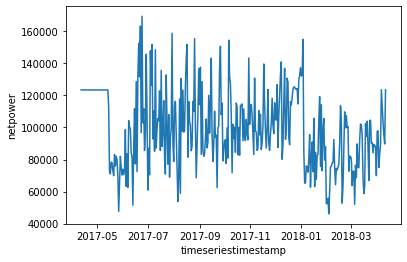

In [103]:
print(max(out.netenergy), min(out.netenergy), max(out.netenergy) - min(out.netenergy))
temp = out.netenergy.apply(lambda x: x+max(out.netenergy) - min(out.netenergy))
sns.lineplot(data=out, x=out.timeseriestimestamp, y=temp)

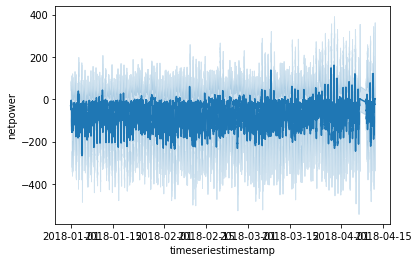

In [81]:
out = df[df.index > '2018-01-01'].reset_index()
sns.lineplot(data=out, x=out.timeseriestimestamp, y=out.netpower)

123469.50989551394


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
srhid                  365 non-null object
timeseriestimestamp    365 non-null datetime64[ns]
netpower               365 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.6+ KB


In [105]:
out = df.groupby(['srhid',pd.Grouper(freq='D')])['netenergy'].sum().reset_index()

In [106]:
out.head()

,srhid,timeseriestimestamp,netpower
0,1004898253,2017-04-11,-62.97314
1,1004898253,2017-04-12,-566.89607
2,1004898253,2017-04-13,15.09950
3,1004898253,2017-04-14,884.11008
4,1004898253,2017-04-15,2.50640


In [177]:
# sns.lineplot(data=out, x=out.timeseriestimestamp, y=out.netpower)#, hue=out.srhid)

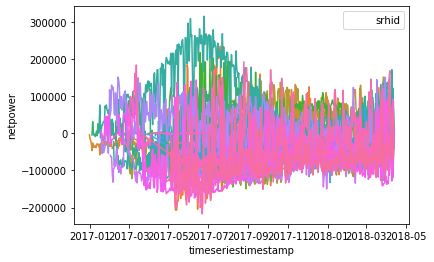

In [108]:
sns.lineplot(data=out, x=out.timeseriestimestamp, y=out.netenergy, hue=out.srhid, legend='full')

In [109]:
some_srhids = list(out.srhid.value_counts().index[0:5])
some_srhids

['_1468250100', '_1501427859', '_1811000851', '_1940097339', '_1590461811']

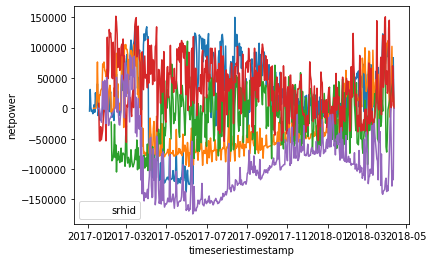

In [110]:
sns.lineplot(data=out[out['srhid'].isin(some_srhids)], x='timeseriestimestamp', y='netenergy', hue='srhid')

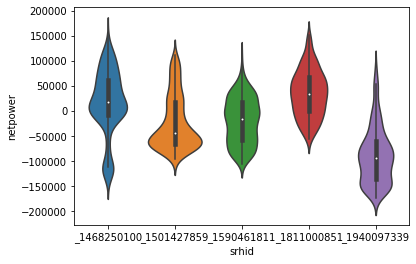

In [111]:
sns.violinplot(data=out[out['srhid'].isin(some_srhids)], y='netenergy', x='srhid')

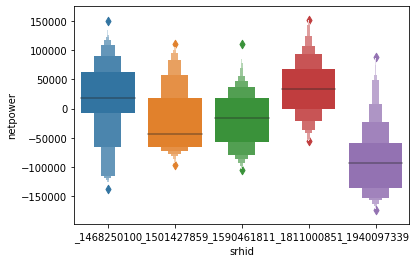

In [113]:
# this one is the best looking
sns.boxenplot(data=out[out['srhid'].isin(some_srhids)], y='netenergy', x='srhid')

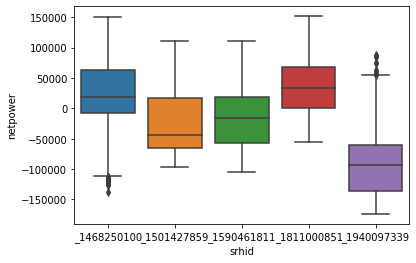

In [114]:
sns.boxplot(data=out[out['srhid'].isin(some_srhids)], y='netenergy', x='srhid')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

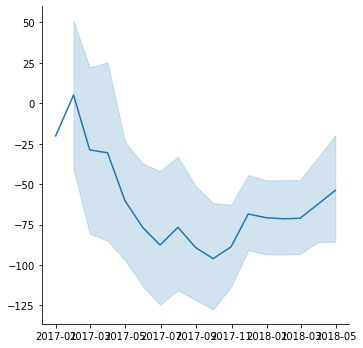

In [179]:
#temp = df.reset_index()
#temp = df.groupby(['srhid',pd.Grouper(freq='M')]).agg({'timeseriesvalue':np.mean,'netenergy':np.mean})
#temp = temp.reset_index()
temp.head()
sns.relplot(x=temp.timeseriestimestamp, y=temp.netenergy, kind='line', data=temp)

In [187]:
#df.head()
temp = df.groupby(['srhid',pd.Grouper(freq='M')]).agg({'netpower':np.mean,'timeseriesvalue':'count'})
temp.rename(columns={'timeseriesvalue':'count_of_records','netpower':'battery_avg_netpower'}, inplace=True)
temp.head()

battery_avg_netpower  count_of_records
srhid      timeseriestimestamp                                        
1004898253 2017-04-30                      -0.221831              7605
           2017-05-31                    -131.971604             14082
           2017-06-30                    -179.440633              9805
           2017-07-31                    -167.330735             14870
           2017-08-31                    -166.835251             14880

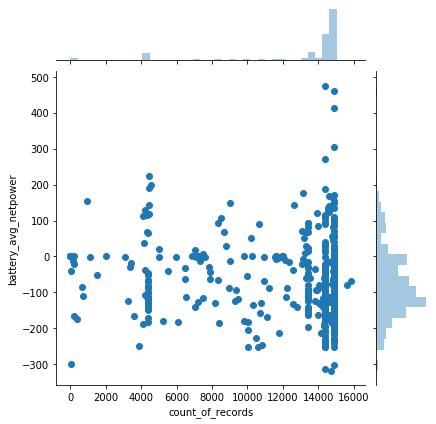

In [188]:
sns.jointplot(x=temp.count_of_records,y=temp.battery_avg_netpower,data=temp)

#  Anomaly Detection
In the last section, we noticed that there are some battery actions that have netpower changes far from the average of the battery. In this section, we will investigate a few ways to detect anomalies and model this behavior.
## P Value
## Z score
## Isolation Forest

In [116]:
df.groupby(['srhid','batterystate']).agg({'netpower':[np.mean,np.std]}).head()

netpower             
                                mean          std
srhid      batterystate                          
1004898253 charge         354.852138   608.620983
           drain         -845.149997   770.425979
1015910829 charge         673.805394  1196.745972
           drain        -1167.172762  1446.032630
1025693371 charge         293.024287   729.296729

In [132]:
# anomly detection
# remove the 0's
# removing zeros because they do not represent an actual battery action, just inaction
# make z scores
#df_z = df 
df_z = df[df['netpower'] != 0]
df_z['z_score'] = (df_z['netpower'] - np.mean(df_z['netpower'])) / np.std(df_z['netpower'])
df_z['netpower'].describe()

C:\Users\slin2\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


count    4.787380e+06
mean    -1.105153e+02
std      1.340328e+03
min     -1.551268e+04
25%     -5.743333e+02
50%      5.000000e+00
75%      3.463333e+02
max      1.424342e+04
Name: netpower, dtype: float64

In [133]:
test_average = np.mean(df[(df['srhid']=='s1004898253') & (df['batterystate'] == 'charge')]['netpower'])
z_scores = (df[(df['srhid']=='s1004898253') & (df['batterystate'] == 'charge')]['netpower'] - test_average)/test_average

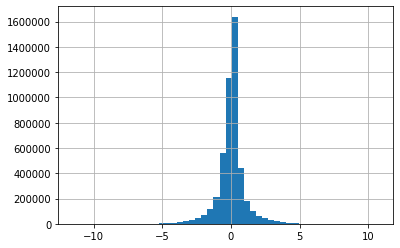

In [135]:
#df_z.loc[:,['netpower','z_score']].plot.scatter(x='netpower',y=np.zeros(len(df_z)))
#df_z.loc[:,['netpower','z_score']].plot.scatter('netpower','z_score')
df_z['z_score'].hist(bins=50)
anomylies = df_z[abs(df_z['z_score']) > 2.5]
#help(pd.DataFrame.plot)

In [193]:
def anomaly_z_score(df, quant_col='netpower',z_score_outlier=2.5):
    mu = np.mean(df[quant_col])
    sigma = np.std(df[quant_col])
    df['z_score'] = (df[quant_col] - mu) / sigma
    anomalies = df[abs(df['z_score']) > z_score_outlier]
    df['outliers'] = df['z_score'].apply(lambda x: 'outlier' if abs(x) > z_score_outlier else 'normal')
    #df[quant_col].plot(kind='box')
    #sns.boxenplot(x=df.index.month,y=df[quant_col], hue=df['outliers'], data=df)
    sns.boxenplot(x=df.index.month,y=df[quant_col], data=df)
    return df
    

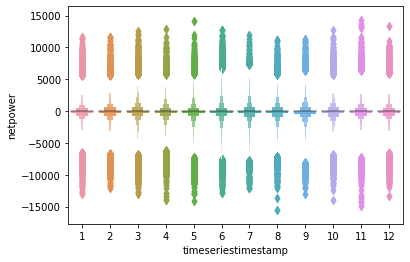

In [194]:
temp = anomaly_z_score(df)

In [ ]:
sns.distplot()

In [ ]:
temp = temp.groupby(['srhid',pd.Grouper(freq='M')])

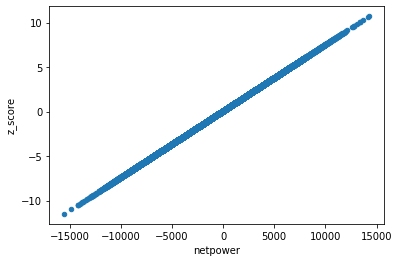

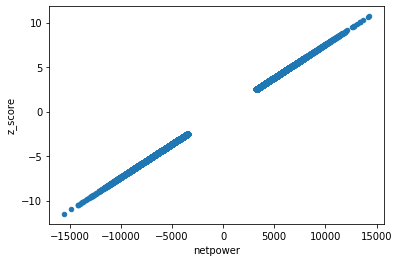

In [136]:
df_z.plot.scatter('netpower','z_score')
anomylies.plot.scatter('netpower','z_score')

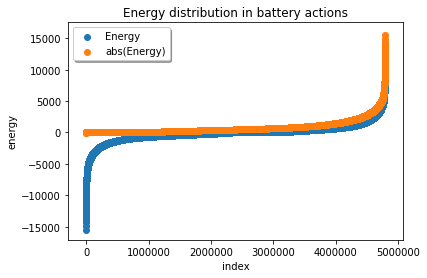

In [137]:
fig = plt.figure()
ax = plt.subplot(111)

#plt.scatter(range(df_z.shape[0]),np.sort(df_z.netpower.values))
l1 = ax.scatter(range(df_z.shape[0]),np.sort(df_z.netpower.values))
l2 = ax.scatter(range(df_z.shape[0]),np.sort(df_z['timeseriesvalue'].values))
ax.legend((l1, l2), ('Energy', 'abs(Energy)'), loc='upper left', shadow=True)
#plt.scatter(range(df_z.shape[0]),np.sort(df_z['timeseriesvalue'].values))
plt.xlabel('index')
plt.ylabel('energy')
plt.title('Energy distribution in battery actions')
plt.show()

the data for netpower looks guassian


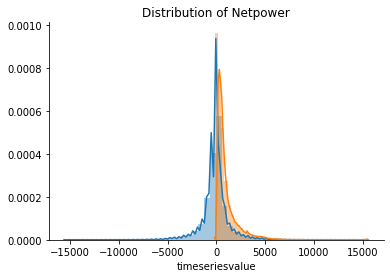

In [140]:
sns.distplot(df_z.netpower)
plt.title('Distribution of Netpower')
sns.distplot(df_z.timeseriesvalue)
sns.despine()
print('the data for netpower looks guassian')

In [139]:
print("Skewness: %f" % df_z['netpower'].skew())
print("Kurtosis: %f" % df_z['netpower'].kurt())

Skewness: -0.277939
Kurtosis: 6.652074


In [141]:
df_charge = df_z[df_z['batterystate'] == 'charge']
df_charge['netpower'].describe()

count    2.473949e+06
mean     6.885944e+02
std      1.007370e+03
min      6.357829e-06
25%      3.898881e+01
50%      3.203333e+02
75%      8.550000e+02
max      1.424342e+04
Name: netpower, dtype: float64

This data is no bueno. There are discrete trends in the power charging states. It looks like 4 different clusters to investigate


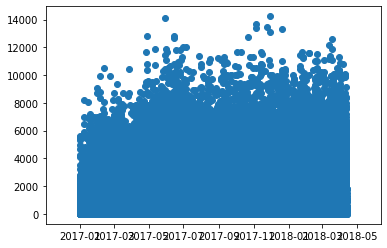

In [142]:
print('This data is no bueno. There are discrete trends in the power charging states. It looks like 4 different clusters to investigate')
#plt.scatter(range(df_charge.shape[0]),np.sort(df_charge['netpower'].values))
plt.scatter(df_charge.index,df_charge['netpower'].values)

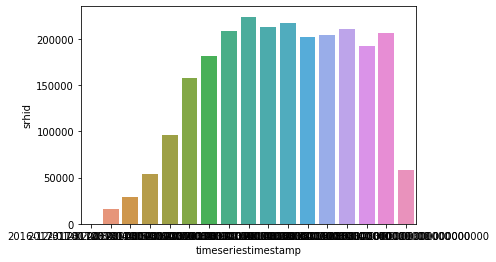

In [143]:
temp = df_charge.groupby(pd.Grouper(freq='M')).count()
sns.barplot(temp.index,temp.srhid)

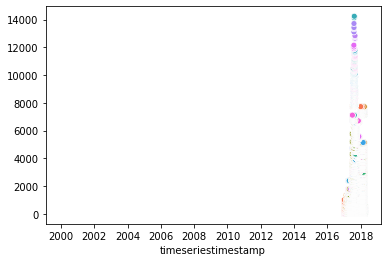

In [148]:
# TODO:
# Do k means clustering analysis on the scatter plot data (date vs netpower)
#df_charge.srhid = df_charge.srhid.apply(lambda x: 's'+str(x))
g = sns.scatterplot(x=df_charge.index, y=np.sort(df_charge['netpower']),hue=df_charge.srhid, legend=False)

#plt.scatter(df_charge.index,np.sort(df_charge['netpower'].values),c=df_charge.srhid)

# Operational Programming
This section marks a look into battery operation optimization.

Batteries have optimal operation boundaries. Often, batteries will last longer if they maintain a charge between 20-80% of their full capacity. Operating outside of these boundaries can lower the life of a battery.

In this next section, I'll find the instances where batteries go outside of their optimal working boundaries to determine if we can operate more efficiently.

Let's return to the batterypercentagestate dataframe, called battery_percent_df:

In [149]:
battery_percent_df.head()

,srhid,timeseriesname,timeseriesvalue
timeseriestimestamp,,,
2018-04-02 23:20:01,1075016781,batteryPercentageState,19.546785
2018-04-02 23:25:00,1075016781,batteryPercentageState,19.561863
2018-04-03 01:30:01,1075016781,batteryPercentageState,19.524618
2018-04-03 00:44:52,2101522395,batteryPercentageState,3.569658
2018-04-03 01:59:51,1682950526,batteryPercentageState,100.000000


In [150]:
# are there any dates that have more than one batterypercentstate?
# eye ball data for numbers bigger than 1
battery_percent_df.groupby(['srhid',pd.Grouper(freq='D')]).count() 
# if dataset is too large
#battery_percent_df.groupby(['srhid',pd.Grouper(freq='D')]).count() > 1

timeseriesname  timeseriesvalue
srhid      timeseriestimestamp                                 
1004898253 2017-04-11                      812              812
           2017-04-12                     1160             1160
           2017-04-13                     1158             1158
           2017-04-14                     1160             1160
           2017-04-15                     1156             1156
           2017-04-16                     1164             1160
           2017-04-17                     1160             1160
           2017-04-18                     1160             1160
           2017-04-19                     1164             1164
           2017-04-20                     1160             1160
           2017-04-21                     1164             1164
           2017-04-22                     1160             1160
           2017-04-23                     1160             1160
           2017-04-24                     1162             1162
           2017-04-25                     1080             1080
           2017-04-26                     1160             1160
           2017-04-27                     1112              540
           2017-04-28                     1130                0
           2017-04-29                     1164                0
           2017-04-30                     1084                0
           2017-05-01                     1160                0
           2017-05-02                     1164                0
           2017-05-03                     1081                0
           2017-05-04                     1160                0
           2017-05-05                     1164                0
           2017-05-06                     1155                0
           2017-05-07                     1160                0
           2017-05-08                     1160                0
           2017-05-09                     1156              552
           2017-05-10                     1155             1155
...                                        ...              ...
2118683719 2018-03-05                      580              580
           2018-03-06                      578              578
           2018-03-07                      580              580
           2018-03-08                      580              580
           2018-03-09                      578              577
           2018-03-10                      580              580
           2018-03-11                      580              580
           2018-03-12                      580              580
           2018-03-13                      580              579
           2018-03-14                      580              580
           2018-03-15                      470              470
           2018-03-16                      278              278
           2018-03-17                      212              212
           2018-03-19                      378              378
           2018-03-20                      268              268
           2018-03-21                      532              532
           2018-03-22                       48               48
           2018-03-25                      478              478
           2018-03-26                      532              532
           2018-03-27                      578              578
           2018-03-28                      382              382
           2018-04-03                      532              532
           2018-04-04                      578              578
           2018-04-05                      578              578
           2018-04-06                      578              578
           2018-04-07                       48               48
           2018-04-09                      532              532
           2018-04-10                      472              472
           2018-04-11                      530              530
           2018-04-12                       42               42


In [151]:
# Uh oh, there are lots of battery movements throughout the day. Here's an example
battery_percent_df[battery_percent_df['srhid'] == '1025693371'].head()
# it looks like we wont be able to group on the date, because there is no true aggregation method to follow

,srhid,timeseriesname,timeseriesvalue
timeseriestimestamp,,,
2018-04-06 12:24:47,1025693371,batteryPercentageState,93.61454
2018-04-06 12:54:47,1025693371,batteryPercentageState,100.00000
2018-04-06 12:29:47,1025693371,batteryPercentageState,96.03201
2018-04-06 13:14:46,1025693371,batteryPercentageState,100.00000
2018-04-06 13:44:46,1025693371,batteryPercentageState,100.00000


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

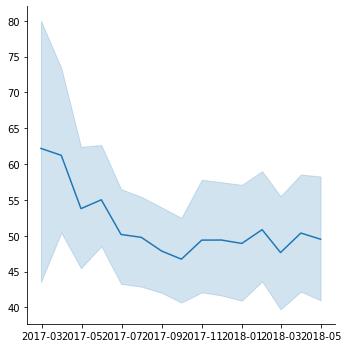

In [166]:
#out = battery_percent_df.groupby(['srhid',pd.Grouper(freq='M')]).agg({'timeseriesvalue':np.mean}).reset_index()
#out.fillna()
out.head()
sns.relplot(x=out.timeseriestimestamp, y=out.timeseriesvalue, kind='line',data=out)

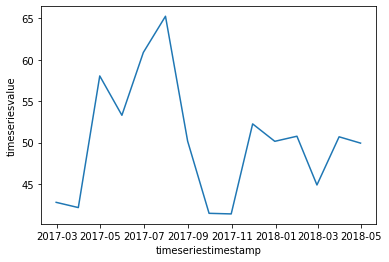

In [160]:
out = battery_percent_df[battery_percent_df['srhid'] == '1025693371'].groupby(pd.Grouper(freq='M')).agg({'timeseriesvalue':np.mean})
sns.lineplot(data=out, x=out.index, y='timeseriesvalue')


In [155]:
out = battery_percent_df.groupby(['srhid',pd.Grouper(freq='D')])

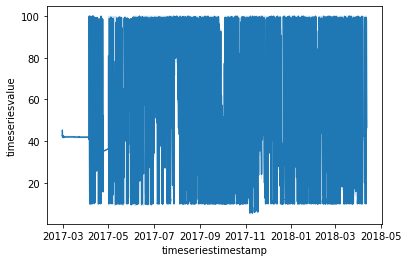

In [156]:
out = battery_percent_df[battery_percent_df['srhid'] == '1025693371'].reset_index()
sns.lineplot(data=out, x='timeseriestimestamp', y='timeseriesvalue')


In [158]:
# add boundaries for 20% and 80% 
battery_percent_df['_80%'] = 80.0
battery_percent_df['_20%'] = 20.0

KeyboardInterrupt: 

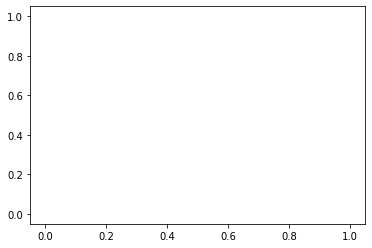

In [159]:
out = battery_percent_df[battery_percent_df['srhid'] == '1025693371'].reset_index()
sns.lineplot(data=out, x='timeseriestimestamp', y='_20%')
sns.lineplot(data=out, x='timeseriestimestamp', y='_80%')
sns.lineplot(data=out, x='timeseriestimestamp', y='timeseriesvalue')

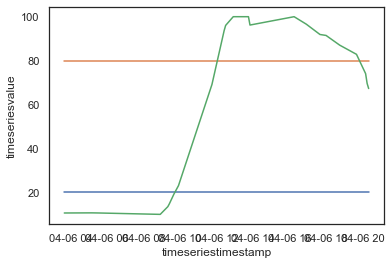

In [161]:
out = battery_percent_df[battery_percent_df['srhid'] == '1025693371'].reset_index()
sns.lineplot(data=out, x='timeseriestimestamp', y='_20%')
sns.lineplot(data=out, x='timeseriestimestamp', y='_80%')
sns.lineplot(data=out, x='timeseriestimestamp', y='timeseriesvalue')

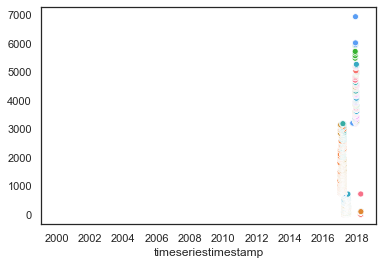

In [371]:
# TODO:
# Do k means clustering analysis on the scatter plot data (date vs netpower)
g = sns.scatterplot(x=df_charge.index, y=np.sort(df_charge['netpower']),hue=df_charge.srhid, legend=False)

#plt.scatter(df_charge.index,np.sort(df_charge['netpower'].values),c=df_charge.srhid)

In [77]:
# return all the times that the battery capacity was above 80% or below 20%
above_80 = battery_percent_df.apply(lambda x: True if x.timeseriesvalue > x['_80%'] else False, axis=1)

In [78]:
below_20 = battery_percent_df.apply(lambda x: True if x.timeseriesvalue < 20 else False, axis=1)

In [79]:
battery_percent_df[above_80 | below_20].head()

,srhid,timeseriesname,timeseriesvalue,_80%,_20%
timeseriestimestamp,,,,,
2018-04-02 23:20:01,1075016781,batteryPercentageState,19.546785,80.0,20.0
2018-04-02 23:25:00,1075016781,batteryPercentageState,19.561863,80.0,20.0
2018-04-03 01:30:01,1075016781,batteryPercentageState,19.524618,80.0,20.0
2018-04-03 00:44:52,2101522395,batteryPercentageState,3.569658,80.0,20.0
2018-04-03 01:59:51,1682950526,batteryPercentageState,100.000000,80.0,20.0


In [80]:
print('there were {} instances where the battery went below 20% capacity'.format(len(battery_percent_df[below_20])))

there were 44 instances where the battery went below 20% capacity


In [81]:
print('there were {} instances where the battery went above 80% capacity'.format(len(battery_percent_df[above_80])))

there were 60 instances where the battery went above 80% capacity


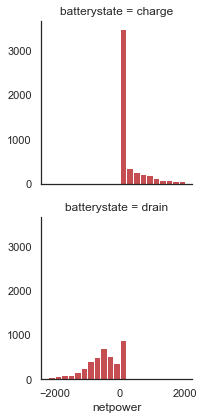

In [166]:
# ridgeplot example with bcub
bins = np.arange(-2200, 2200, 200)
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(data=df, row='batterystate')
g = g.map(plt.hist, 'netpower', bins=bins, color='r')

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100])

In [93]:
df.head()

,srhid,timeseriesname,timeseriesvalue,batterystate,netpower
timeseriestimestamp,,,,,
2018-04-03 00:30:00,1075016781,powerProduction,0.0000,charge,0.0000
2018-04-03 01:15:00,2101522395,powerFeedIn,0.0000,charge,0.0000
2018-04-02 22:30:00,1075016781,powerFeedIn,0.0000,charge,0.0000
2018-04-03 00:45:00,1075016781,powerPurchased,496.6109,charge,496.6109
2018-04-03 01:15:00,1075016781,powerProduction,0.0000,charge,0.0000


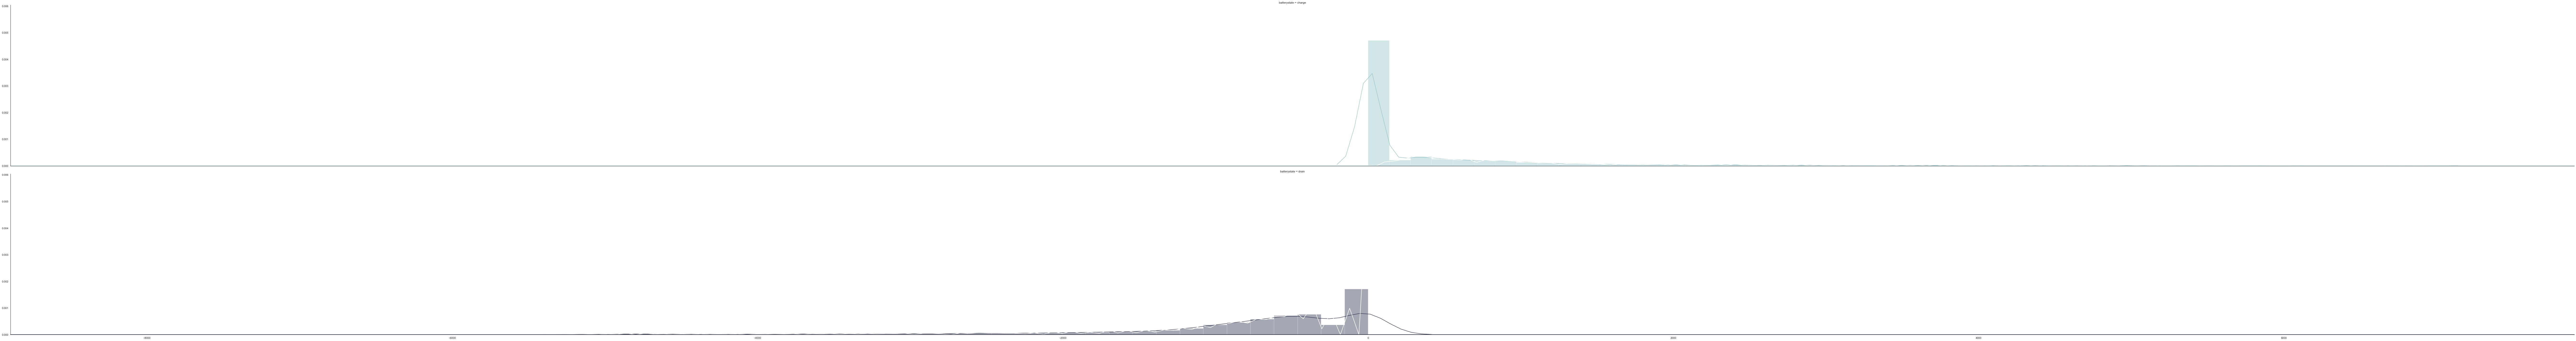

In [186]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(2, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="batterystate", hue="batterystate", aspect=15, height=10, palette=pal)

# Draw the densities in a few steps
g.map(sns.distplot, "netpower")
g.map(sns.kdeplot, "netpower", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

#g.set_titles("")
#g.set(yticks=[])
#g.despine(bottom=True, left=True)

In [ ]:
# Initialize the FacetGrid object
temp = df['srhid'].isin(some_srhids_srhids)
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="batterystate", hue="batterystate", aspect=15, height=10, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "netpower", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "netpower", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

In [172]:
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()

    ax.text(0, .2, label, fontweight="bold", color=color,
           ha="left", va="center", transform=ax.transAxes)

#label(g)

In [189]:
#g.map(label, "batterystate")

# Set the subplots to overlap
#g.fig.subplots_adjust(hspace=-.25)

In [107]:
# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [190]:
df.head()

,srhid,timeseriesname,timeseriesvalue,batterystate,netpower
timeseriestimestamp,,,,,
2018-04-03 00:30:00,1075016781,powerProduction,0.0000,charge,0.0000
2018-04-03 01:15:00,2101522395,powerFeedIn,0.0000,charge,0.0000
2018-04-02 22:30:00,1075016781,powerFeedIn,0.0000,charge,0.0000
2018-04-03 00:45:00,1075016781,powerPurchased,496.6109,charge,496.6109
2018-04-03 01:15:00,1075016781,powerProduction,0.0000,charge,0.0000


In [191]:
df.groupby(by=df.index.hour).mean()

,timeseriesvalue,netpower
timeseriestimestamp,,
0,373.920141,-109.250081
1,352.357339,-0.173280
2,297.517436,-58.467595
3,323.968926,-88.676737
4,310.499759,-34.025653
5,351.872685,-12.208466
6,355.008895,-31.050367
7,394.071740,-106.945012
8,624.085958,-152.018837


In [192]:
df['hour'] = df.index.hour

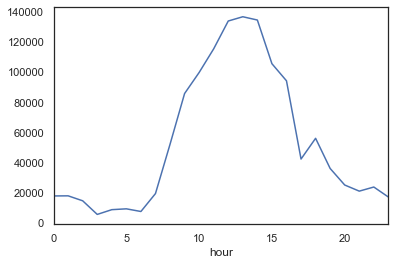

In [208]:
df[df['timeseriesname']=='powerProduction'].groupby('hour').sum()['netpower'].plot.line()

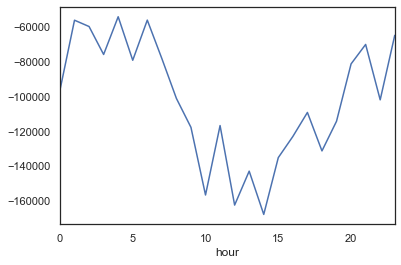

In [207]:
df[df['timeseriesname']=='powerConsumption'].groupby('hour').sum()['netpower'].plot.line()

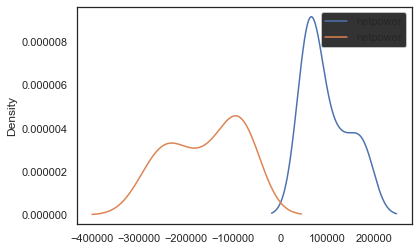

In [218]:
df[df['batterystate']=='charge'].groupby('hour').sum()['netpower'].plot.kde()
df[df['batterystate']=='drain'].groupby('hour').sum()['netpower'].plot.kde()
plt.legend()

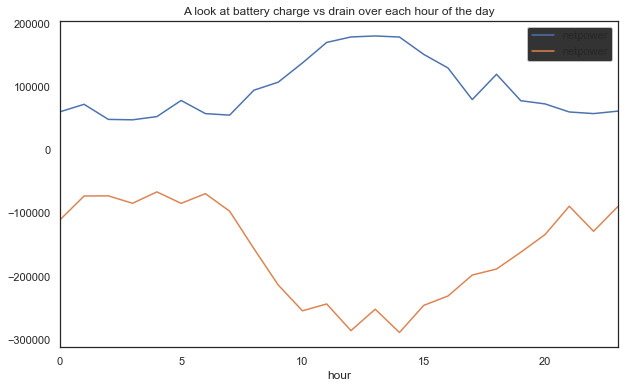

In [226]:
df[df['batterystate']=='charge'].groupby('hour').sum()['netpower'].plot.line(
    title='A look at battery charge vs drain over each hour of the day')
df[df['batterystate']=='drain'].groupby('hour').sum()['netpower'].plot.line(figsize=(10,6),legend=True)
plt.legend()

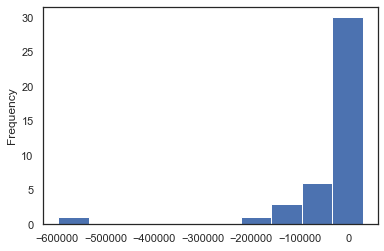

In [230]:
df.groupby('srhid').sum()['netpower'].plot.hist()

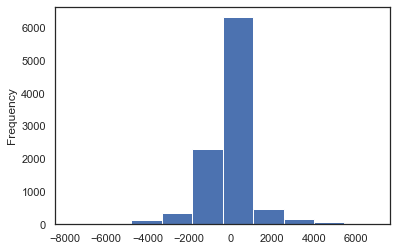

In [232]:
# net battery power for all batteries are skewed toward discharge/drain
df['netpower'].plot.hist()

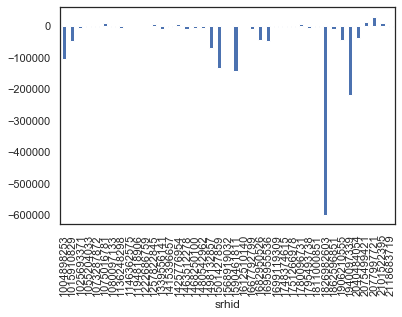

In [235]:
# almost every battery has a net negative drain over the time series. This seems impossible
df.groupby('srhid').sum()['netpower'].plot.bar()

In [237]:
df['srhid'] = df['srhid'].apply(lambda x: 's'+str(x))

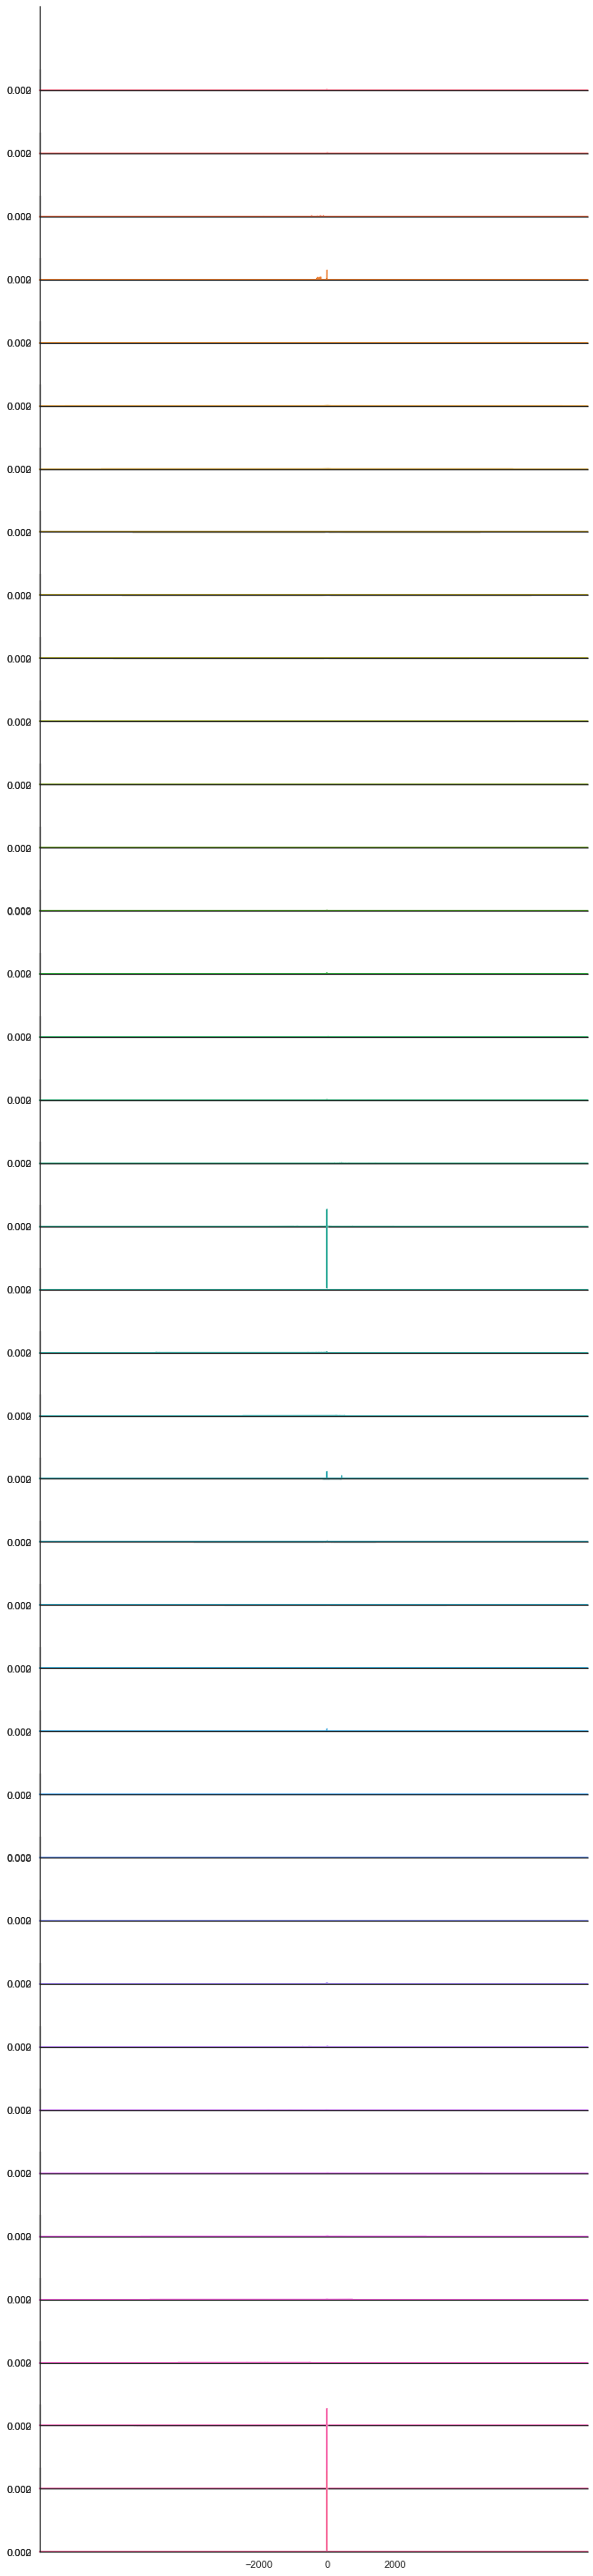

In [325]:

g = sns.FacetGrid(
    #df
    df[~df['srhid'].isin(['s1826982603'])]
    ,row='srhid',hue='srhid'
                 , height=1, aspect=9)
# Draw the densities in a few steps
g.map(sns.kdeplot, "netpower", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
#g.map(sns.kdeplot, "netpower", clip_on=False)#, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)
g.set_titles("")
#g.set_titles(row_template=df['srhid'])
g.set(yticks=[0,.002],xticks=
      [-2000,2000,0]
      #[x for x in range(-1000,1000,750)]
     )
#g.despine(bottom=True, left=True)
#g.set_ylabels()
#g.set_axis_labels(x_var='netpower',y_var='srhid')

count    6365.000000
mean     -232.032163
std      1433.727087
min     -7711.777000
25%      -799.146600
50%      -279.299100
75%       318.000000
max      6934.629000
Name: netpower, dtype: float64

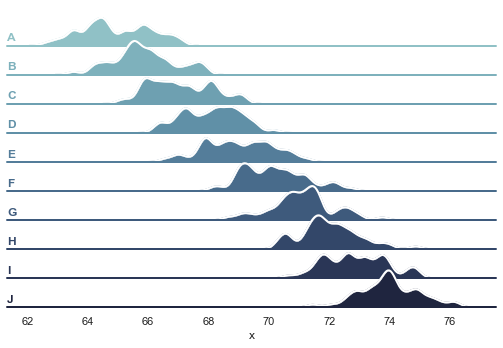

In [120]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)